In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 
from datetime import datetime, timedelta
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


# personal modules
import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md


sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [2]:
outcomes_df = ml.retrieve_data(filename = 'data/outcomes.csv', headers = True, set_ind = 0)

In [3]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [4]:
outcomes_df.replace(to_replace='t', value=1, inplace=True)
outcomes_df.replace(to_replace='f', value=0, inplace=True)

In [5]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,0,0.0,1,1.0,0,1.0,0.0,0.0,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,0,0.0,1,1.0,1,1.0,1.0,0.0,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,0,0.0,0,1.0,1,0.0,0.0,0.0,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,1,1.0,1,1.0,1,0.0,1.0,0.0,63.0,6.0,2.0


In [6]:
projects_df = ml.retrieve_data(filename = 'data/projects.csv', headers = True, set_ind = 0)

In [7]:
project_info = pd.merge(projects_df, pd.DataFrame(outcomes_df['fully_funded']), how = 'inner', right_index = True, left_index = True)

In [8]:
project_info.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,1
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,0
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,0
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,0
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,1


### Date Transformation and Narrowing

In [9]:
project_info.date_posted.dtype

dtype('O')

In [10]:
project_info['date_posted'] = ml.convert_dates(project_info['date_posted'])

In [11]:
project_info['year'] = project_info['date_posted'].apply(lambda x: x.year)

In [12]:
project_info['year'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002])

In [13]:
project_info = project_info[(project_info['date_posted'] >= datetime.strptime('2011-01-01', '%Y-%m-%d')) & (project_info['date_posted'] <= datetime.strptime('2013-12-31', '%Y-%m-%d'))]            
                                     

In [14]:
project_info['year'].unique()

array([2013, 2012, 2011])

### Column Details Exploration

In [15]:
project_info.describe().round(3).transpose()

,count,mean,std,min,25%,50%,75%,max
school_ncesid,328293.0,2.503127e+11,1.648173e+11,1.000050e+10,6.372301e+10,2.400090e+11,3.904440e+11,6.100008e+11
school_latitude,353151.0,3.686900e+01,4.927000e+00,1.824900e+01,3.391600e+01,3.667600e+01,4.068000e+01,6.725800e+01
school_longitude,353151.0,-9.539800e+01,1.811800e+01,-1.716910e+02,-1.172470e+02,-8.988600e+01,-8.076200e+01,-6.662800e+01
school_zip,353151.0,5.630176e+04,3.104352e+04,4.100000e+02,2.938800e+04,6.061300e+04,9.000700e+04,9.992600e+04
fulfillment_labor_materials,353151.0,3.222000e+01,2.484000e+00,3.000000e+01,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01
total_price_excluding_optional_support,353151.0,5.313720e+02,8.440690e+02,3.703000e+01,2.887500e+02,4.272700e+02,6.067200e+02,1.397254e+05
total_price_including_optional_support,353151.0,6.251440e+02,9.930230e+02,4.356000e+01,3.397100e+02,5.026700e+02,7.137900e+02,1.643828e+05
students_reached,353050.0,9.418700e+01,1.569870e+02,1.000000e+00,2.300000e+01,3.100000e+01,1.000000e+02,1.214300e+04
fully_funded,353151.0,7.010000e-01,4.580000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
year,353151.0,2.012077e+03,8.130000e-01,2.011000e+03,2.011000e+03,2.012000e+03,2.013000e+03,2.013000e+03


In [16]:
def organize_variables(df, col_names, indicator, var_dict = None):
    if var_dict is None:
        var_dict = {'binary': [], 'tops': [], 'drop': [], 'ids': [], 'geo': [], 'multi': [], 'numeric': []}
    
    if indicator == 'binary':
        var_dict[indicator] += col_names
    elif indicator == 'multi':
        var_dict[indicator] += col_names
    elif indicator == 'numeric':
        var_dict[indicator] += col_names
    elif indicator == 'geo':
        var_dict[indicator] += col_names
    elif indicator == 'ids':
        var_dict[indicator] += col_names
    elif indicator == 'tops':
        var_dict[indicator] += col_names
    elif indicator == 'drop':
        var_dict[indicator] += col_names
    
    return var_dict

In [17]:
# check column types
def check_col_types(df):
    return pd.DataFrame(df.dtypes, df.columns).rename({0: 'data_type'}, axis = 1)

In [18]:
# check column types
ml.check_col_types(project_info)

,data_type
teacher_acctid,object
schoolid,object
school_ncesid,float64
school_latitude,float64
school_longitude,float64
school_city,object
school_state,object
school_zip,float64
school_metro,object
school_district,object


In [19]:
# view values across columns
def view_cols(df):
    '''
    View unique values across columns in given data frame.
    '''
    for col in df.columns:
        print(col)
        print(df[col].unique())
        print()

In [20]:
ml.view_cols(project_info)

teacher_acctid
['ebc7c90b6c92a069432e0714b8d93dfd' 'de83b4c1f6428a15032c207c1d5e572a'
 'f4c9ed095b85458dcf858e25f203af00' ... '4a7fd60460dccc2a4d09069e53c6b964'
 '8c458627ae58a3057232e8de4f1f51ad' 'e0b03d3b814958dbba3d0236f237aab6']

schoolid
['5aca9711ff0e4b37db48701f46f73036' 'd91a805b213bf74ae77b94e0de2b73ad'
 '9310d3eb447a4e46bc5fc31ed007ceac' ... 'fda28249bfc517eb67f57875063f7c4a'
 '1cac20ff36dab7b47161703fdd0134a5' 'c17558ef1c387875778e241a9054946d']

school_ncesid
[1.71371006e+11 1.60153000e+11 3.30261000e+11 ... 3.41053005e+11
 1.91269001e+11 3.61941004e+11]

school_latitude
[41.972419 43.501154 42.888244 ... 41.287719 41.046086 40.958734]

school_longitude
[ -88.174597 -112.05678   -71.320224 ...  -74.79199   -95.74642
  -72.994883]

school_city
['Bartlett' 'Idaho Falls' 'Derry' ... 'Mead' 'Mahopac' 'Miller Place']

school_state
['IL' 'ID' 'NH' 'VA' 'SC' 'KY' 'FL' 'WY' 'NY' 'NM' 'NC' 'AZ' 'MI' 'MO'
 'TX' 'NJ' 'CO' 'MT' 'CA' 'AK' 'MN' 'CT' 'GA' 'IN' 'MA' 'PA' 'TN' 'OK'
 'LA' 'O

In [21]:
# log ids
type_dict = organize_variables(project_info, col_names = ['teacher_acctid', 'schoolid', 'school_ncesid'], indicator = 'ids')


In [22]:
# log binary variables
type_dict = organize_variables(project_info, col_names = ['school_charter', 'school_magnet', 'school_year_found', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligibile_almost_home_match'], indicator = 'binary', var_dict = type_dict)


In [23]:
# log variables to drop
type_dict = organize_variables(project_info, col_names = ['school_latitude', 'school_longitude'], indicator = 'drop', var_dict = type_dict)


In [24]:
# log geographical info to keep
type_dict = organize_variables(project_info, col_names = ['school_city', 'school_state', 'school_zip'], indicator = 'geo', var_dict = type_dict)


In [25]:
# log items with multiple values to convert to dummy variables
type_dict = organize_variables(project_info, col_names = ['school_metro', 'teacher_prefix', 'resource_type', 'poverty_level', 'grade_level'], indicator = 'multi', var_dict = type_dict)


In [26]:
# log variables to create dummy variables for solely top-occuring values
type_dict = organize_variables(project_info, col_names = ['school_district', 'school_county', 'school_state', 'school_city', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area'], indicator = 'tops', var_dict = type_dict)


In [27]:
type_dict

{'binary': ['school_charter',
  'school_magnet',
  'school_year_found',
  'school_nlns',
  'school_kipp',
  'school_charter_ready_promise',
  'teacher_teach_for_america',
  'teacher_ny_teaching_fellow',
  'eligible_double_your_impact_match',
  'eligibile_almost_home_match'],
 'tops': ['school_district',
  'school_county',
  'school_state',
  'school_city',
  'primary_focus_subject',
  'primary_focus_area',
  'secondary_focus_subject',
  'secondary_focus_area'],
 'drop': ['school_latitude', 'school_longitude'],
 'ids': ['teacher_acctid', 'schoolid', 'school_ncesid'],
 'geo': ['school_city', 'school_state', 'school_zip'],
 'multi': ['school_metro',
  'teacher_prefix',
  'resource_type',
  'poverty_level',
  'grade_level'],
 'numeric': []}

### Outlier Evaluation

In [28]:
maxes = ml.view_max_mins(project_info, max = True)
maxes.tail().round(2)

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,fully_funded,year
0.996,5.509600e+11,48.05,-70.29,98952.0,35.0,3930.71,4624.36,999.0,1.0,2013.0
0.997,5.512330e+11,48.87,-70.23,99343.0,35.0,4810.63,5659.56,999.0,1.0,2013.0
0.998,5.514750e+11,61.19,-69.97,99507.0,35.0,6136.87,7219.85,999.0,1.0,2013.0
0.999,5.516830e+11,61.22,-69.11,99577.0,35.0,8699.96,10235.25,999.0,1.0,2013.0
1.000,6.100008e+11,67.26,-66.63,99926.0,35.0,139725.41,164382.84,12143.0,1.0,2013.0


In [29]:
likely_outliers_upper = ml.view_likely_outliers(project_info)
likely_outliers_upper.tail()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,fully_funded,year
0.996,2.666241e-09,0.005071,-0.006003,0.002716,0.0,0.185147,0.185147,0.000000,0.0,0.0
0.997,4.954968e-04,0.016860,-0.000961,0.003951,0.0,0.223858,0.223859,0.000000,0.0,0.0
0.998,4.390019e-04,0.252270,-0.003614,0.001651,0.0,0.275690,0.275690,0.000000,0.0,0.0
0.999,3.771853e-04,0.000442,-0.012383,0.000703,0.0,0.417654,0.417654,0.000000,0.0,0.0
1.000,1.057089e-01,0.098641,-0.035873,0.003505,0.0,15.060468,15.060462,11.155155,0.0,0.0


In [30]:
mins = ml.view_max_mins(project_info, max = False)
mins

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,fully_funded,year
0.000,1.000050e+10,18.249140,-171.690554,410.0,30.0,37.0300,43.5600,1.0,0.0,2011.0
0.001,1.002700e+10,20.864705,-158.192448,1118.0,30.0,132.8400,156.2800,2.0,0.0,2011.0
0.002,1.010200e+10,21.344914,-158.012455,1602.0,30.0,134.3330,158.0430,3.0,0.0,2011.0
0.003,1.017400e+10,21.384429,-157.871713,1610.0,30.0,135.9900,159.9900,4.0,0.0,2011.0
0.004,1.020400e+10,21.512068,-157.728836,1840.0,30.0,137.1900,161.4000,5.0,0.0,2011.0
0.005,1.023700e+10,25.397676,-155.096330,1852.0,30.0,138.4200,162.8500,5.0,0.0,2011.0
0.006,1.026500e+10,25.599142,-149.808700,2026.0,30.0,139.3900,163.9900,6.0,0.0,2011.0
0.007,1.029113e+10,25.699131,-149.720276,2119.0,30.0,140.1205,164.8505,6.0,0.0,2011.0
0.008,1.033900e+10,25.743486,-124.206627,2122.0,30.0,140.8900,165.7500,6.0,0.0,2011.0
0.009,2.001800e+10,25.777018,-123.725756,2127.0,30.0,141.5500,166.5300,6.0,0.0,2011.0


In [31]:
likely_outliers_lower = ml.view_likely_outliers(project_info, max = False)
likely_outliers_lower

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,fully_funded,year
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,2.649951e-03,0.143325,-0.078619,1.726829,0.0,2.587362,2.587695,1.000000,NaN,0.0
0.002,7.479675e-03,0.023015,-0.001138,0.432916,0.0,0.011239,0.011281,0.500000,NaN,0.0
0.003,7.127319e-03,0.001851,-0.000891,0.004994,0.0,0.012335,0.012319,0.333333,NaN,0.0
0.004,2.948710e-03,0.005969,-0.000905,0.142857,0.0,0.008824,0.008813,0.250000,NaN,0.0
0.005,3.234090e-03,0.180625,-0.016690,0.006522,0.0,0.008966,0.008984,0.000000,NaN,0.0
0.006,2.735179e-03,0.007932,-0.034093,0.093952,0.0,0.007008,0.007000,0.200000,NaN,0.0
0.007,2.545706e-03,0.003906,-0.000590,0.045903,0.0,0.005241,0.005247,0.000000,NaN,0.0
0.008,4.651396e-03,0.001726,-0.170409,0.001416,0.0,0.005492,0.005456,0.000000,NaN,0.0
0.009,9.361638e-01,0.001303,-0.003872,0.002356,0.0,0.004685,0.004706,0.000000,NaN,0.0


#### Create copy of dataframe to manipulate and explore

In [32]:
manip_df = project_info[list(project_info.columns)]

In [33]:
manip_df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,year
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,1,2013
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,0,2013
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,0,2013
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,0,2013
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,1,2013


#### Outlier Removal

In [34]:
# total price and students reached values should not be inf 
ml.remove_over_under_threshold(manip_df, col = 'total_price_excluding_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'total_price_including_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'students_reached', min_val = 0, max_val = False, lwr_threshold = 0.005, upr_threshold = False)


In [35]:
# check that expected values were removed
likely_outliers_lower_post = ml.view_likely_outliers(manip_df, max = False)
likely_outliers_lower_post

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,fully_funded,year
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,2.649951e-03,0.143325,-0.078619,1.726829,0.0,0.011051,0.011057,0.000000,NaN,0.0
0.002,7.479675e-03,0.023015,-0.001138,0.432916,0.0,0.012375,0.012354,0.000000,NaN,0.0
0.003,7.127319e-03,0.001851,-0.000891,0.004994,0.0,0.008899,0.008940,0.200000,NaN,0.0
0.004,2.948710e-03,0.005969,-0.000905,0.142857,0.0,0.008966,0.008984,0.000000,NaN,0.0
0.005,3.234090e-03,0.180625,-0.016690,0.006522,0.0,0.007008,0.007001,0.000000,NaN,0.0
0.006,2.735179e-03,0.007932,-0.034093,0.093952,0.0,0.005237,0.005245,0.000000,NaN,0.0
0.007,2.545706e-03,0.003906,-0.000590,0.045903,0.0,0.005567,0.005521,0.166667,NaN,0.0
0.008,4.651396e-03,0.001726,-0.170409,0.001416,0.0,0.004614,0.004646,0.000000,NaN,0.0
0.009,9.361638e-01,0.001303,-0.003872,0.002356,0.0,0.004027,0.004024,0.000000,NaN,0.0


### Feature Creation

#### Binary Conversion

In [36]:
# check for null values
ml.print_null_freq(manip_df)

value                                    False   True 
variable                                              
date_posted                             353151       0
eligible_almost_home_match              353151       0
eligible_double_your_impact_match       353151       0
fulfillment_labor_materials             353151       0
fully_funded                            353151       0
grade_level                             353145       6
poverty_level                           353151       0
primary_focus_area                      353116      35
primary_focus_subject                   353116      35
resource_type                           353109      42
school_charter                          353151       0
school_charter_ready_promise            353151       0
school_city                             353151       0
school_county                           353151       0
school_district                         352722     429
school_kipp                             353151       0
school_lat

In [37]:
# convert binary values
manip_df.replace({'t': 1, 'f': 0}, inplace=True)

In [38]:
# confirm change
manip_df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,year
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,Grades 3-5,30.0,444.36,522.78,7.0,0,0,2013-12-31,1,2013
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,Grades 3-5,30.0,233.24,274.40,30.0,0,0,2013-12-31,0,2013
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,Grades 6-8,30.0,285.09,335.40,230.0,0,0,2013-12-31,0,2013
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,Grades PreK-2,30.0,232.94,274.05,18.0,0,0,2013-12-31,0,2013
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,Grades 6-8,30.0,513.41,604.01,70.0,1,0,2013-12-31,1,2013


In [39]:
manip_df.columns

Index(['teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude',
       'school_longitude', 'school_city', 'school_state', 'school_zip',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded', 'year'],
      dtype='object')

In [40]:
type_dict['drop']

['school_latitude', 'school_longitude']

In [41]:
def drop_unwanted(df, drop_list):
    df.drop(drop_list, axis = 1, inplace = True)

In [42]:
 drop_unwanted(manip_df, type_dict['drop'])

#### Dummy variable creation - Multi-value columns

In [43]:
type_dict['multi']

['school_metro',
 'teacher_prefix',
 'resource_type',
 'poverty_level',
 'grade_level']

In [44]:
# convert multi-value columns to binary dummy variables
manip_df = ml.replace_dummies(manip_df, type_dict['multi'])


In [45]:
# confirm columns were created
manip_df.columns

Index(['teacher_acctid', 'schoolid', 'school_ncesid', 'school_city',
       'school_state', 'school_zip', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area',
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded', 'year', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'school_metro_nan',
       'teacher_prefix_Dr.', 'teacher_prefix_Mr.', 'teacher_prefix_Mrs.',
       'teacher_prefix_Ms.', 'teacher_prefix_nan', 'resource_type_Books',
       'resource_type_Other', 'reso

### Split Train and Test Sets

In [46]:
# def create_expanding_splits(df, total_periods, dates, train_period_base, test_period_size, period = 'month', defined_start = None):
#     num_months = total_periods / test_period_size
#     months_used = train_period_base
    
#     tt_sets = []
    
#     while months_used < total_periods:
        
#         print(train_period_base)
#         train, test = ml.time_series_split(df, date_col = dates, train_size = train_period_base, test_size = test_period_size, increment = period, specify_start = defined_start)
#         print("train: {}, test: {}".format(train.shape, test.shape))
#         tt_sets.append((train, test))
#         train_period_base += test_period_size
#         months_used += test_period_size
    
#     return tt_sets


In [102]:
all_sets = ml.create_expanding_splits(manip_df, total_periods = 36, dates = 'date_posted', train_period_base = 12, test_period_size = 3, period = 'month', defined_start = '2011-01-01')


12
train: (104547, 55), test: (36917, 55)
15
train: (141318, 55), test: (15640, 55)
18
train: (156824, 55), test: (31978, 55)
21
train: (188309, 55), test: (33947, 55)
24
train: (222062, 55), test: (24079, 55)
27
train: (245843, 55), test: (19454, 55)
30
train: (265235, 55), test: (44368, 55)
33
train: (309067, 55), test: (44084, 55)


### Create training-set-specific dummy variables

In [93]:
type_dict['tops']

['school_district',
 'school_county',
 'school_state',
 'school_city',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area']

In [103]:
def determine_top_dummies(test_train_set_list, var_dict, threshold, max_options = 10):
    set_distro_dummies = []
    counter = 1
    for train, test in test_train_set_list:
        dummies_dict = {}
        print(var_dict['tops'])
        for col in train[var_dict['tops']]:
            print("col: ", col)
            col_sum = train[col].value_counts().sum()
            top = train[col].value_counts().nlargest(max_options)
            top_value = 0
            num_dummies = 0

            while ((top_value / col_sum) < threshold) & (num_dummies < max_options):
                print("num_before: ", num_dummies)
                top_value += top[num_dummies]
                num_dummies += 1
            print("num after: ", num_dummies)
            print(top_value / col_sum)

            keep_dummies = list(top.index)[:num_dummies]
            dummies_dict[col] = keep_dummies
            
        counter += 1
        set_distro_dummies.append(dummies_dict)

    return set_distro_dummies




In [104]:
specific_dummies = determine_top_dummies(all_sets, type_dict, threshold = 0.5, max_options = 10)

['school_district', 'school_county', 'school_state', 'school_city', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area']
col:  school_district
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.28383761011106856
col:  school_county
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.32861775086803063
col:  school_state
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num after:  6
0.5072072847618775
col:  school_city
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.22076195395372417
col:  primary_focus_subject
num_before:  0
num_before:  1
num_before:  2
num 

num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.2553593875632764
col:  school_county
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.30759138122796764
col:  school_state
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num after:  6
0.5253341376515166
col:  school_city
num_before:  0
num_before:  1
num_before:  2
num_before:  3
num_before:  4
num_before:  5
num_before:  6
num_before:  7
num_before:  8
num_before:  9
num after:  10
0.19754557279393745
col:  primary_focus_subject
num_before:  0
num_before:  1
num_before:  2
num after:  3
0.5664366515837104
col:  primary_focus_area
num_before:  0
num_before:  1
num after:  2
0.705369532428356
col:  secondary_focus_subject
num_before:  0
num_before:  1
num_before:  

In [105]:
# def lower_vals_to_other(set_specific_dummies, test_train_set_list):
#     counter = 0
#     for i, set_dict in enumerate(set_specific_dummies):
#         print("starting set {}...".format(counter))
#         counter += 1
#         for col, vals in set_dict.items():
#             train, test = test_train_set_list[i]
#             train.loc[~train[col].isin(vals), col] = 'Other'
#             test.loc[~test[col].isin(vals), col] = 'Other'


In [106]:
ml.lower_vals_to_other(set_specific_dummies = specific_dummies, test_train_set_list = all_sets)

starting set 0...
starting set 1...
starting set 2...
starting set 3...
starting set 4...
starting set 5...
starting set 6...
starting set 7...


In [107]:
def plot_top_distros(train_test_tuples, var_dict, set_num):
    for i, col in enumerate(var_dict['tops']):
        train, test = train_test_tuples[set_num]
        plot_title = "Projects by {} for Training Set {}".format(col, set_num)
        train[col].value_counts().sort_index().plot(kind='bar', title = plot_title)
        plt.show()

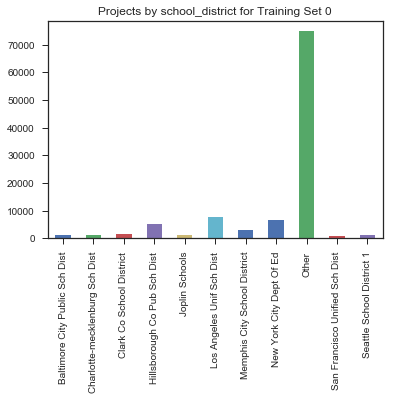

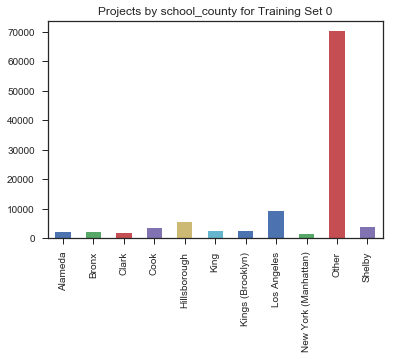

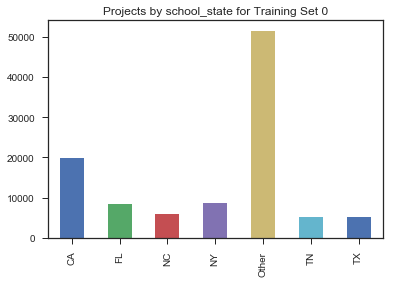

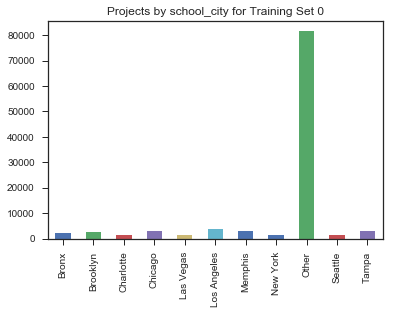

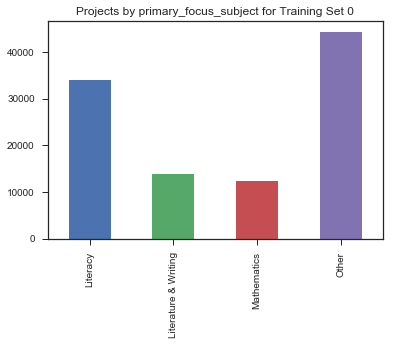

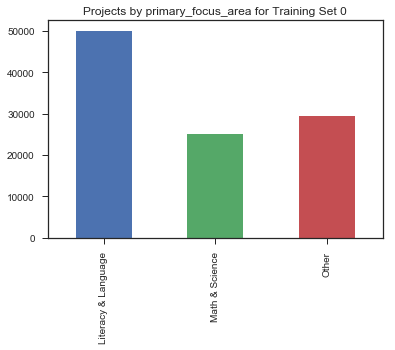

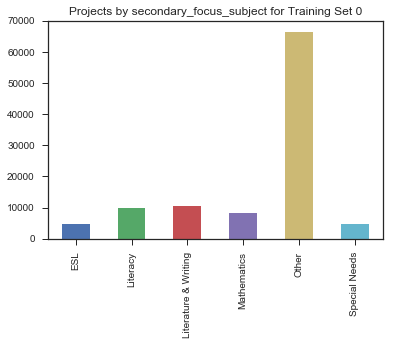

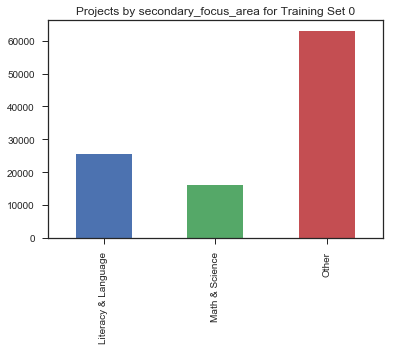

In [108]:
ml.plot_top_distros(all_sets, type_dict, set_num = 0)

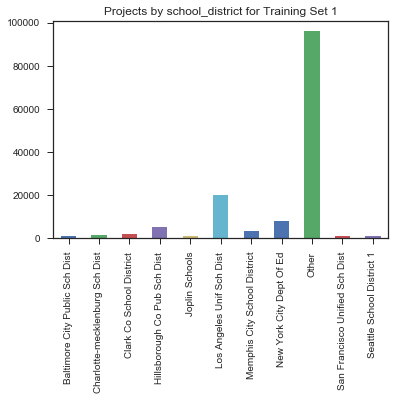

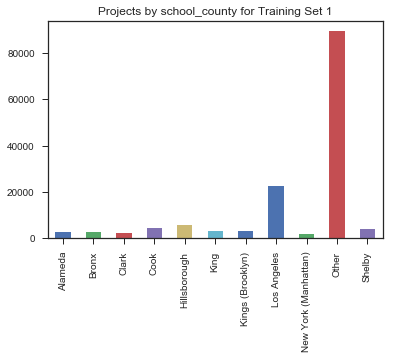

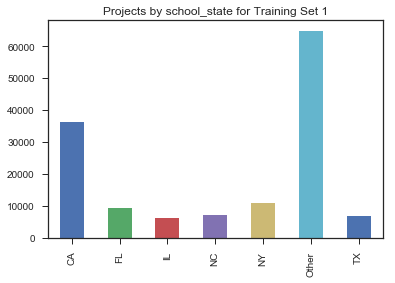

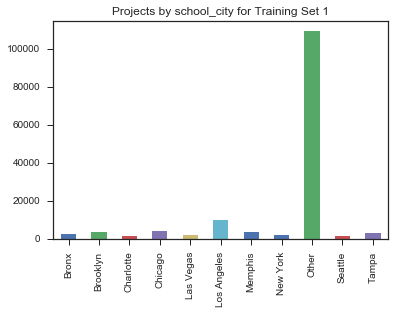

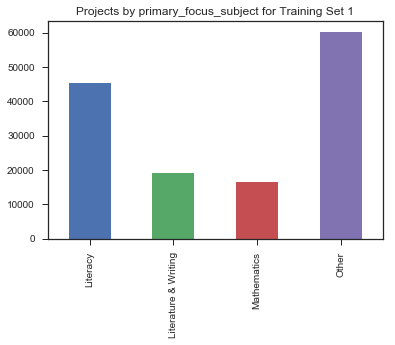

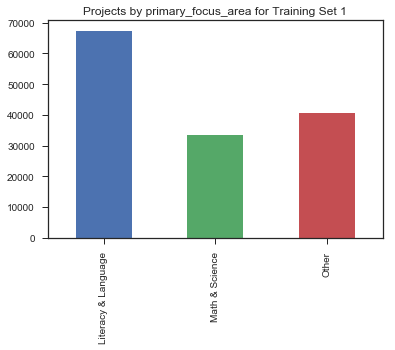

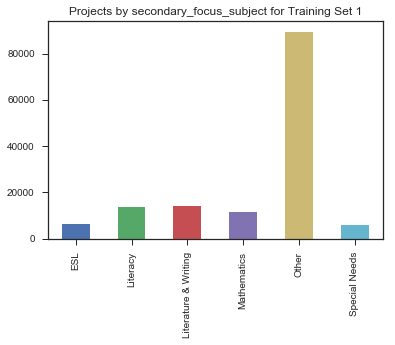

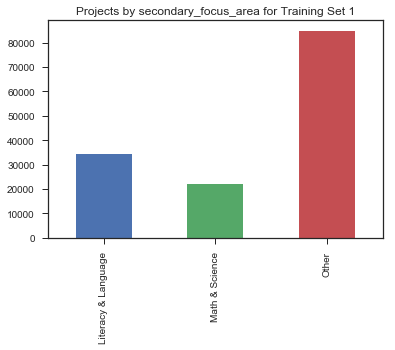

In [109]:
ml.plot_top_distros(all_sets, type_dict, set_num = 1)

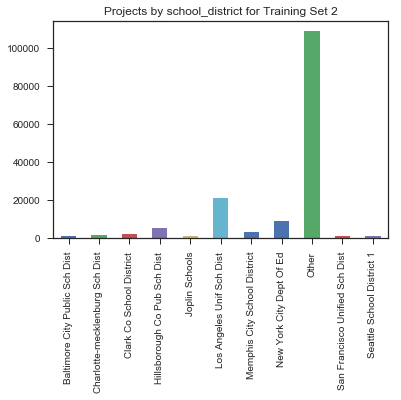

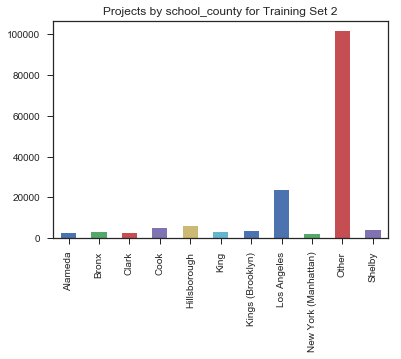

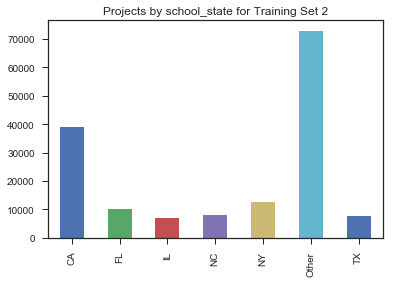

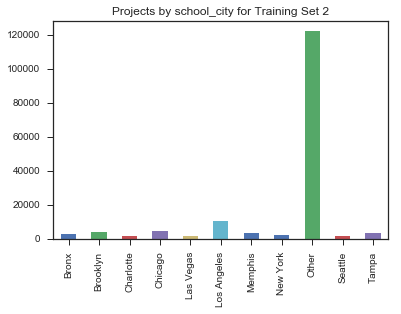

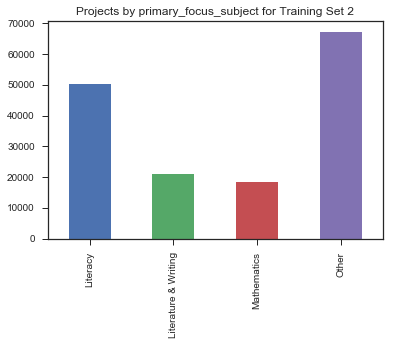

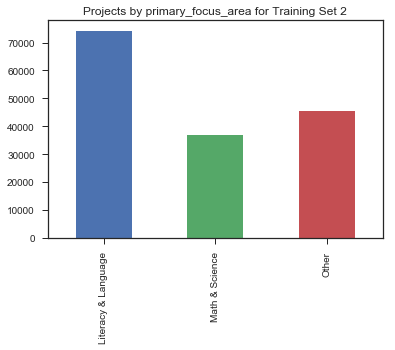

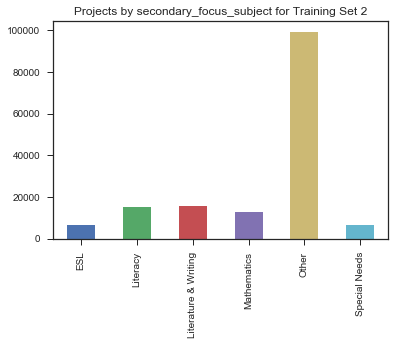

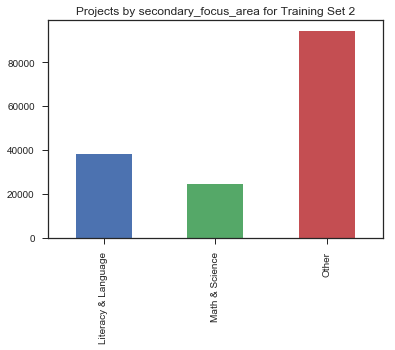

In [111]:
ml.plot_top_distros(all_sets, type_dict, set_num = 2)

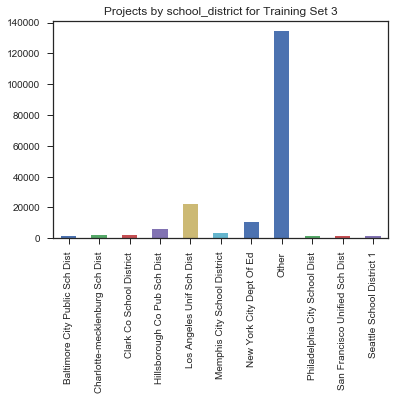

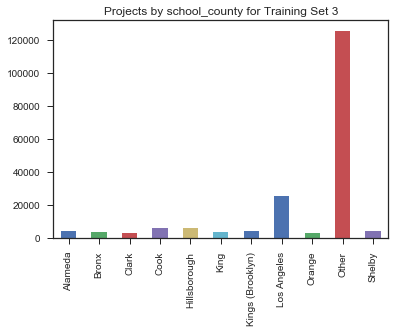

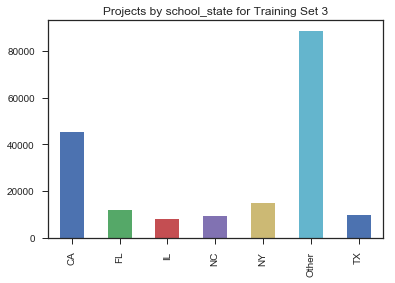

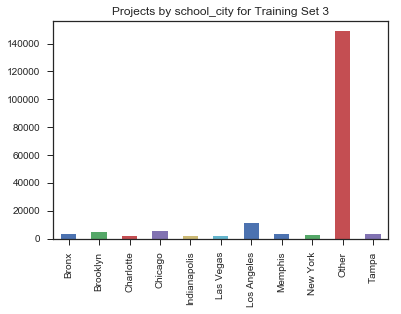

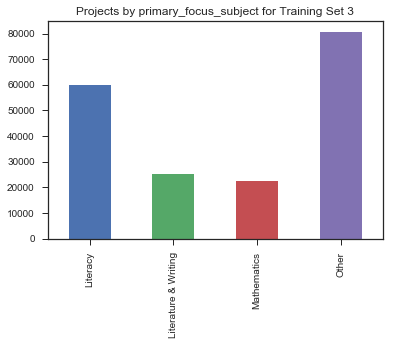

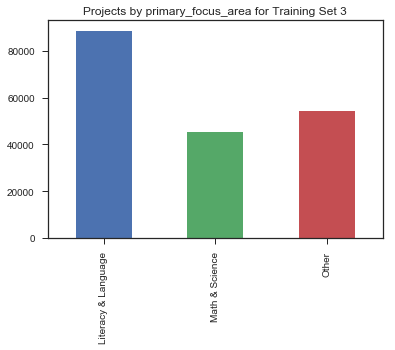

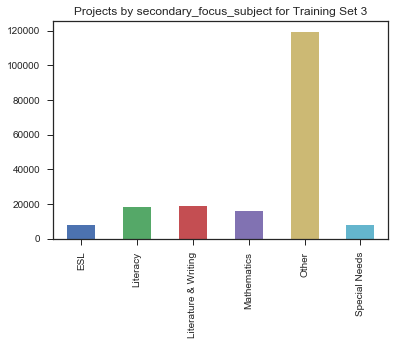

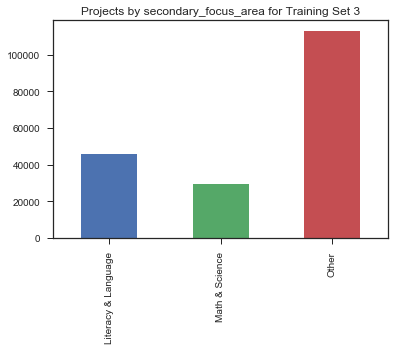

In [112]:
ml.plot_top_distros(all_sets, type_dict, set_num = 3)

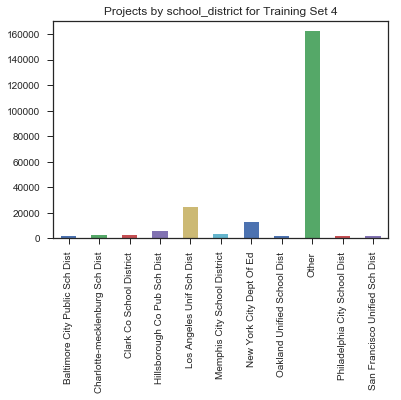

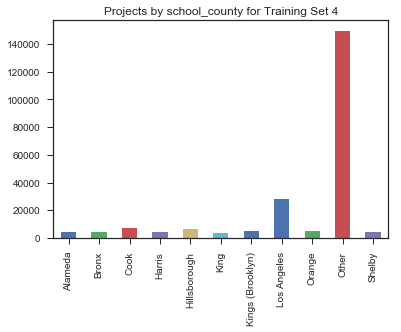

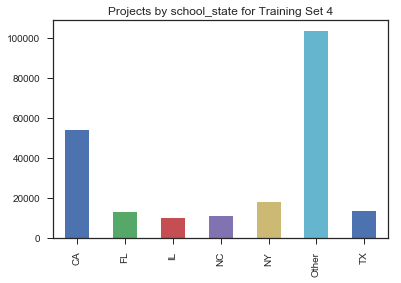

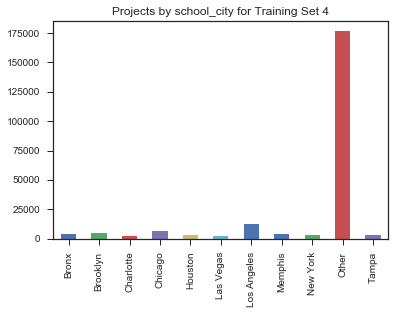

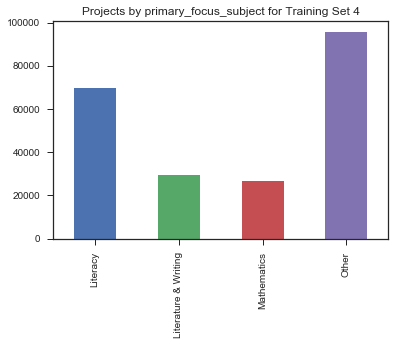

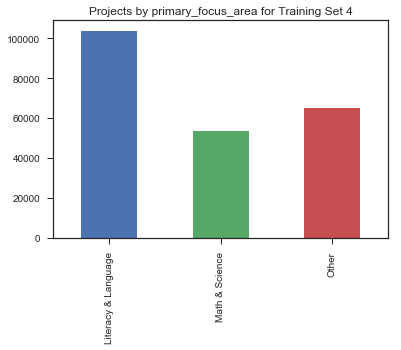

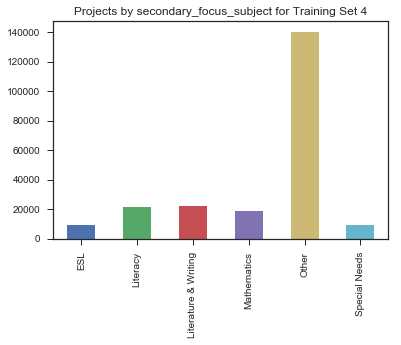

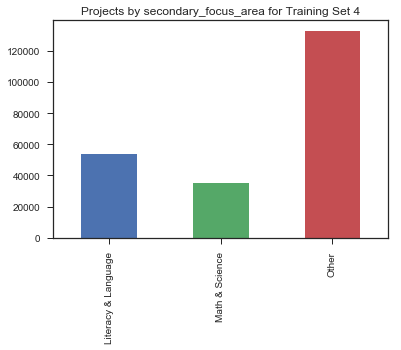

In [113]:
ml.plot_top_distros(all_sets, type_dict, set_num = 4)

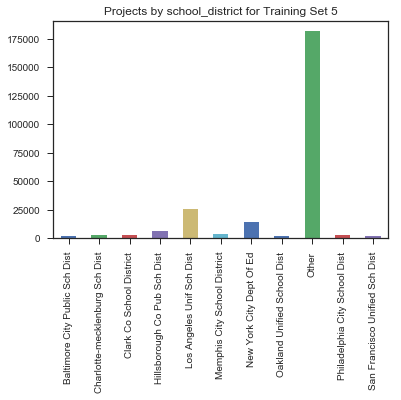

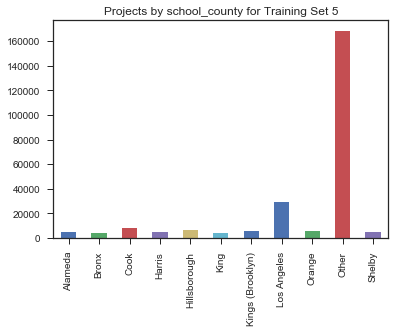

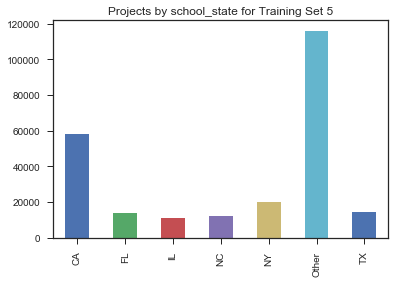

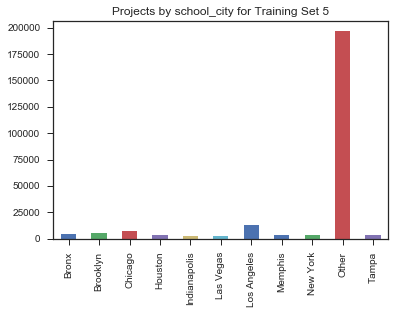

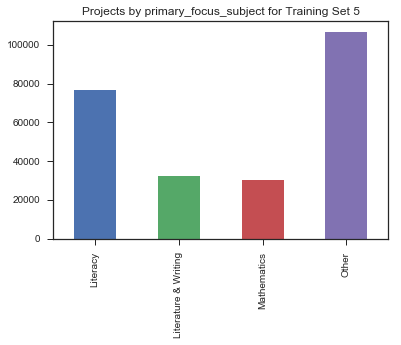

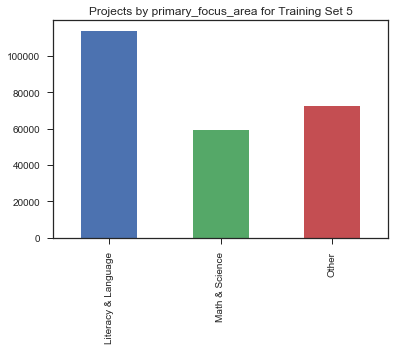

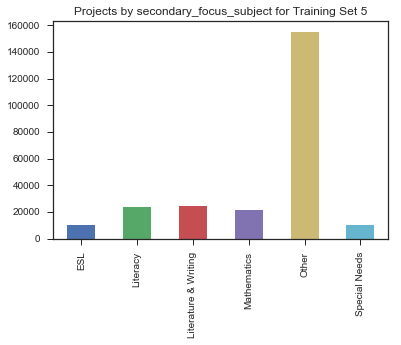

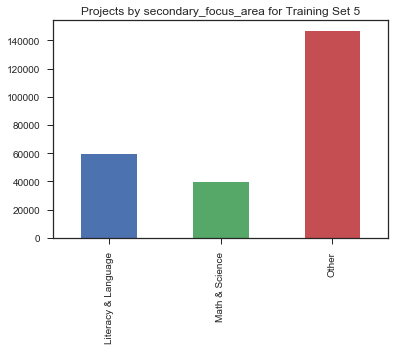

In [114]:
ml.plot_top_distros(all_sets, type_dict, set_num = 5)

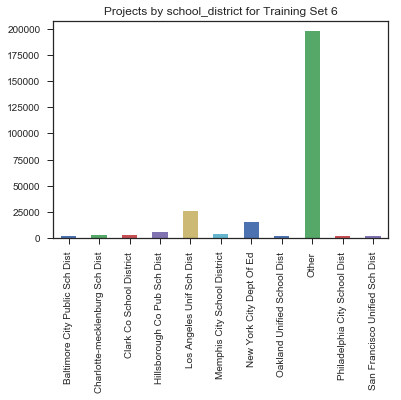

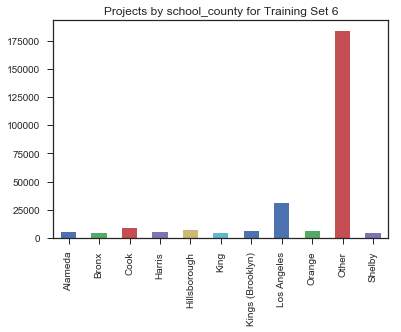

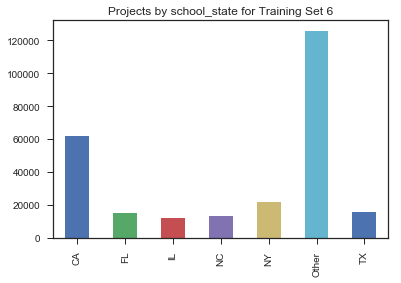

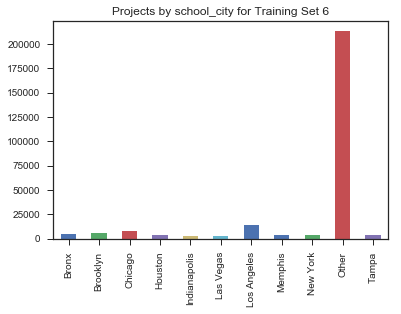

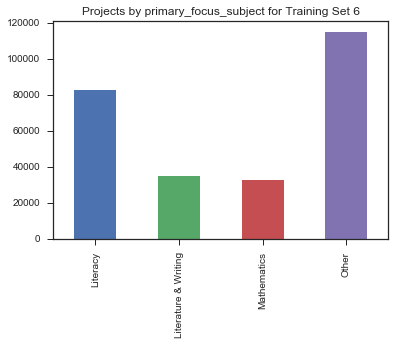

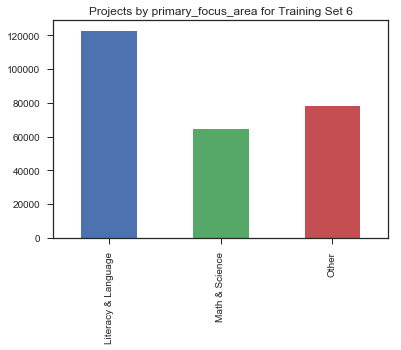

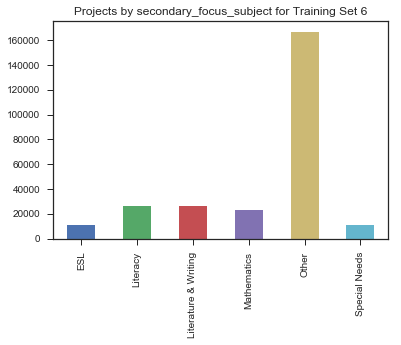

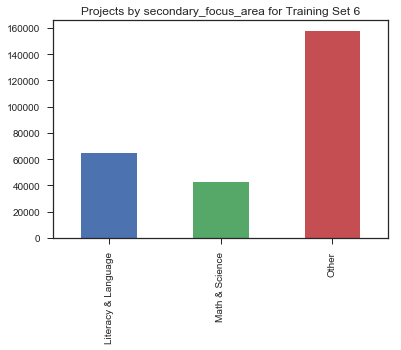

In [115]:
ml.plot_top_distros(all_sets, type_dict, set_num = 6)

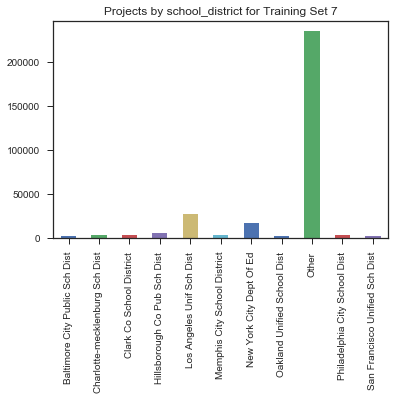

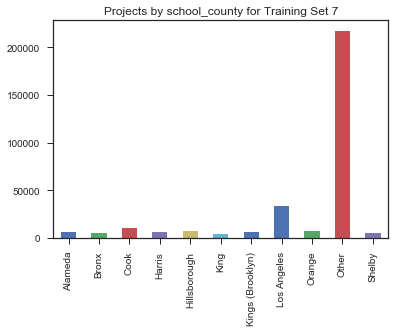

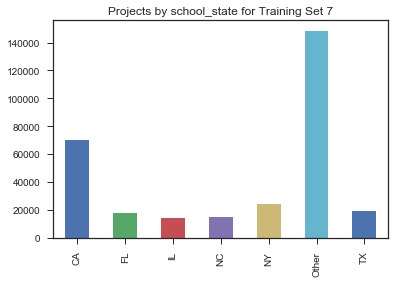

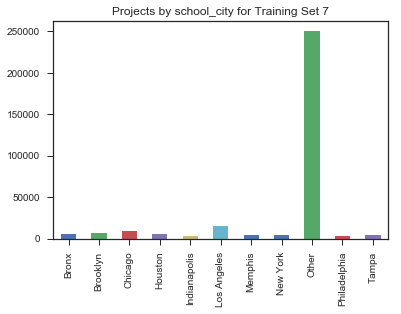

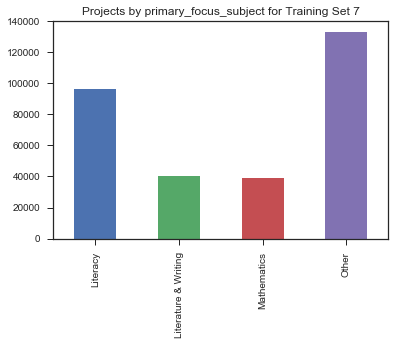

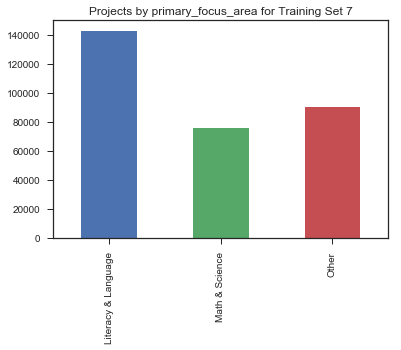

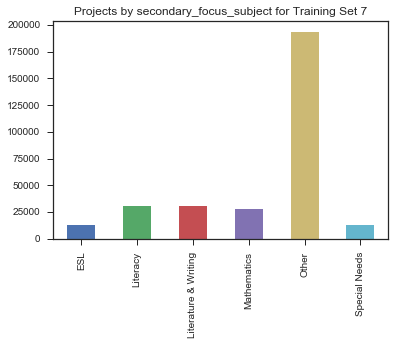

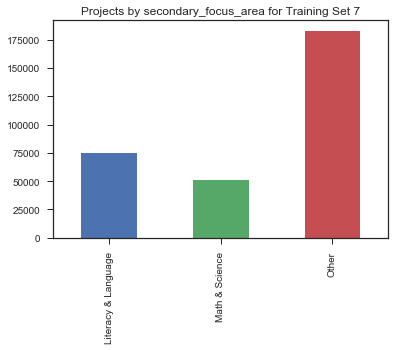

In [116]:
ml.plot_top_distros(all_sets, type_dict, set_num = 7)

In [54]:
for train, test in all_sets:
    for col in train[type_dict['tops']]:
#         try:
#             train[col].plot(kind = 'bar')
#         except:
#             look = train[col].astype('category')
            
        def encoder(data):
        '''Map the categorical variables to numbers to work with scikit learn'''
        for col in data.columns:
            if data.dtypes[col] == "object":
                le = preprocessing.LabelEncoder()
                le.fit(data[col])
                data[col] = le.transform(data[col])
        return data
        
        labels_encoder = LabelEncoder()
        labels_encoder.fit(train[col])
        print(encouder.classes_)
        encoded = labels_encoder.transofrm(train[col])
        encoded = encoded.reshape(-1, 1)

        full_encoder = OneHotEncoder()
        plottable = full_encoder.fit_transform(encoded)


        print(plottable)
        plottable.plot(kind = 'bar')

            
#             cat_features = ['color', 'director_name', 'actor_2_name']
# enc = preprocessing.LabelEncoder()
# enc.fit(cat_features)
# new_cat_features = enc.transform(cat_features)
# print new_cat_features # [1 2 0]
# new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
# ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
# print ohe.fit_transform(new_cat_features)


TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
for var in type_dict['tops']:
    manip_df[var].plot(kind='bar')
    plt.show()

In [110]:
# fill null values for which zero where it is most likely true value
ml.basic_fill_vals(manip_df, "fully_funded", method = "replace", replace_with = 0)


In [ ]:
def record_nulls(df):
    for col in list(df.columns):
        title = col + "_was_null"
        df[title] = df[col].isnull().astype(int)
    df = df.loc[:, (df != 0).any(axis=0)]

In [ ]:
# record_nulls(manip_df)

In [ ]:
manip_df.head()

In [ ]:
ml.print_null_freq(manip_df)

In [ ]:
exp.view_dist(manip_df, geo_columns= True,
             fig_size = (20, 20),
             labels = ["Feature Distributions", "Feature", "Frequency"])

In [ ]:
# # exp.view_dist(manip_df, geo_columns= True,
#              fig_size = (20, 20),
#              labels = ["Feature Distributions", "Feature", "Frequency"])


In [ ]:
manip_df.head()

In [ ]:
pd.get_dummies(manip_df, prefix="dummy", prefix_sep='_', dummy_na=False, columns=None)

In [ ]:
params_test = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': [None],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }

In [63]:
small_grid = { 
    "Random Forest":{'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    "Logistic Regression": { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    "Naive Bayes" : {},
    "Decision Tree": {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None,'sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

In [74]:
for clf_type, params in small_grid.items():
    print(clf_type)
    print(params)
    print()
    for tried in list(itertools.product(params.values())):
        print(tried)
    

Random Forest
{'n_estimators': [100, 10000], 'max_depth': [5, 50], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 10], 'n_jobs': [-1]}

([100, 10000],)
([5, 50],)
(['sqrt', 'log2'],)
([2, 10],)
([-1],)
Logistic Regression
{'penalty': ['l1', 'l2'], 'C': [1e-05, 0.001, 0.1, 1, 10]}

(['l1', 'l2'],)
([1e-05, 0.001, 0.1, 1, 10],)
Naive Bayes
{}

Decision Tree
{'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10, 20, 50, 100], 'max_features': [None, 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}

(['gini', 'entropy'],)
([1, 5, 10, 20, 50, 100],)
([None, 'sqrt', 'log2'],)
([2, 5, 10],)
SVM
{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']}

([1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],)
(['linear'],)
KNN
{'n_neighbors': [1, 5, 10, 25, 50, 100], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}

([1, 5, 10, 25, 50, 100],)
(['uniform', 'distance'],)
(['auto', 'ball_tree', 'kd_tree'],)


In [114]:
# parameters for looping sourced from example at https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10]}
dt_parameter = list(dt_params.keys())
# for params in list(itertools.product(*dt_params.values())):
#     print(params)
list_params = list(itertools.product(*dt_params.values()))

In [117]:
all_dicts = []
for params in list_params:
    kwargs_dict = dict(zip(dt_parameter, params))
    all_dicts.append(kwargs_dict)


In [157]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11, 3)
(11, 1)
(3, 3)
(3, 1)


In [158]:
dec_tree.fit(x_train, y_train)
train_pred = dec_tree.predict(x_train)
test_pred = dec_tree.predict(x_test)
train_acc = accuracy(x_train, y_train)
test_acc = accuracy(x_test, y_test)
print(train_acc, test_acc)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets